In [1]:
from importlib import reload

In [2]:
import torch
from torchvision import models
from itertools import chain
from collections import OrderedDict
import copy
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage import transform
import pandas as pd
import json
from train_mnist_model import Net as ConvNet
from train_mnist_model import preprocessing

import imp
LRP = imp.load_source('LRP', '../__init__.py')
from LRP.lrp import LRP
from LRP.utils import flatten_model
from skimage import io
from skimage import transform 

In [3]:
def norm_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

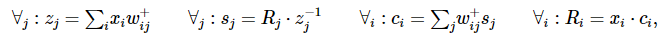

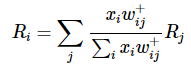

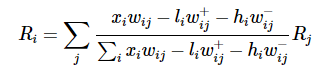

# MNIST test

## Conv net

In [4]:
model = ConvNet()
model.load_state_dict(torch.load('mnist_model.ph'))
model = model.eval()
# model = utils.redefine_nn(model, rule='z_plus_no_bias')
lrp = LRP(model, rule='z_plus_no_bias')

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(preprocessing),

#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [6]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(preprocessing),

#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

#### add hook to modules

In [7]:
outputs_back = []
forward_back = []
for module in flatten_model(lrp.model):
    module.register_backward_hook(lambda *x: outputs_back.append([*x]))
for module in flatten_model(lrp.model):
    module.register_forward_hook(lambda *x: forward_back.append(x))

Label  7
Prediction 7
relevance mean tensor(0.0036)


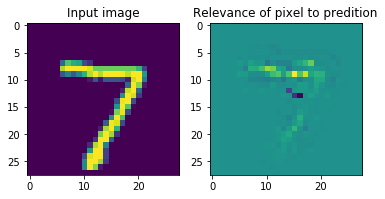

In [8]:
cmap = plt.cm.get_cmap('seismic')
for num, (image, label) in enumerate(test_loader):
    if num > 0:
        break
    print('Label ', label.item())
    output = lrp.forward(image)
    print('Prediction', output.argmax().item())
    _, ax = plt.subplots(1,2)
    ax[0].imshow(image.squeeze().detach())
    ax[0].title.set_text('Input image')
    relevance = lrp.relprop()
    print('relevance mean', relevance.abs().mean())
    ax[1].imshow(norm_tensor(relevance.squeeze()))
    ax[1].title.set_text('Relevance of pixel to predition')
    plt.show()
  

In [9]:
print(outputs_back[0])
print(outputs_back[0][0].weight.data.shape)

[Linear(in_features=50, out_features=10, bias=True), (tensor([[0.0373, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0238, 0.0300,
         0.0113, 0.0138, 0.0000, 0.0000, 0.0000, 0.0000, 0.0880, 0.0000, 0.0540,
         0.0448, 0.0000, 0.0000, 0.0000, 0.0763, 0.0133, 0.0598, 0.0121, 0.0000,
         0.0000, 0.0000, 0.0431, 0.0000, 0.0000, 0.0000, 0.0378, 0.0000, 0.1059,
         0.0000, 0.0000, 0.0748, 0.0971, 0.0167, 0.0709, 0.0144, 0.0000, 0.0000,
         0.0000, 0.0274, 0.0000, 0.0000, 0.0475]]),), (tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]),)]
torch.Size([10, 50])


In [10]:
print(forward_back[-1][1])


(tensor([[12.2152,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.0982,
          7.0481,  8.2738,  4.7399,  0.0000,  0.0000,  0.0000,  0.0000, 13.4166,
          0.0000, 10.2471, 18.0449,  0.0000,  0.0000,  0.0000, 14.0441,  5.9366,
         14.8710,  7.7922,  0.0000,  0.0000,  0.0000, 10.8475,  0.0000,  0.0000,
          0.0000, 11.5001,  0.0000, 14.5824,  0.0000,  0.0000, 13.6079, 17.2339,
          6.9097, 11.8143,  5.7238,  0.0000,  0.0000,  0.0000,  7.9398,  0.0000,
          0.0000, 12.0509]], grad_fn=<LRP_relu_funcBackward>),)


In [11]:
forward_back[-1][0].weight.data.clamp_(0,float('inf'))
forward_back[-1][0].bias.data.zero_()
Z = forward_back[-1][0].weight.data@forward_back[-1][1][0].T
S = (outputs_back[0][-1][0]/Z.T).T
R = forward_back[-1][0].weight.data.T@S
R = R*forward_back[-1][1][0].T

In [12]:
R.T

tensor([[0.0373, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0238, 0.0300,
         0.0113, 0.0138, 0.0000, 0.0000, 0.0000, 0.0000, 0.0880, 0.0000, 0.0540,
         0.0448, 0.0000, 0.0000, 0.0000, 0.0763, 0.0133, 0.0598, 0.0121, 0.0000,
         0.0000, 0.0000, 0.0431, 0.0000, 0.0000, 0.0000, 0.0378, 0.0000, 0.1059,
         0.0000, 0.0000, 0.0748, 0.0971, 0.0167, 0.0709, 0.0144, 0.0000, 0.0000,
         0.0000, 0.0274, 0.0000, 0.0000, 0.0475]], grad_fn=<PermuteBackward>)

In [13]:
print(outputs_back[3])


[Linear(in_features=320, out_features=50, bias=True), (tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2691e-03, 6.4335e-04, 0.0000e+00,
         0.0000e+00, 1.0590e-02, 6.7803e-04, 0.0000e+00, 1.3825e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2643e-03, 8.7132e-04,
         0.0000e+00, 1.4290e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.2690e-03, 0.0000e+00, 0.0000e+00, 1.0155e-04,
         0.0000e+00, 6.9853e-03, 2.5647e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.2496e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6533e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9090e-02, 2.5222e-02,
         0.0000e+00, 3.7065e-02, 5.3300e-02, 0.0000e+00, 1.3617e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+0

In [14]:
forward_back[-4][0].weight.data.clamp_(0,float('inf'))
forward_back[-4][0].bias.data.zero_()
Z = forward_back[-4][0].weight.data@forward_back[-4][1][0].T
S = (outputs_back[3][-1][0]/Z.T).T
R = forward_back[-4][0].weight.data.T@S
R = R*forward_back[-4][1][0].T
torch.all(outputs_back[3][1][0] == R.T)


tensor(True)

In [15]:
print(outputs_back[5][1][0][0,0,:8,:8])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0073],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0106],
        [0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0001, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [16]:
print(outputs_back[5][2][0][0,0,:8,:8])

tensor([[0.0000, 0.0000, 0.0000, 0.0073],
        [0.0006, 0.0000, 0.0000, 0.0106],
        [0.0007, 0.0000, 0.0001, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


In [17]:
forward_back[-6][1][0][0,0,:8,:8]

tensor([[-3.3494, -3.8154, -4.5899, -5.6475, -7.1490, -3.4210, -2.5071, -1.4721],
        [-4.6962, -4.6894, -5.2922, -8.9936, -8.9739, -2.6640,  1.1531,  3.5821],
        [-1.2173, -2.4717, -3.2323, -4.6992, -3.9165, -4.3420, -0.2528,  3.2282],
        [ 0.1250, -1.4418, -3.3366, -3.9596, -2.8348, -3.8649, -2.1348, -1.5266],
        [ 0.3797, -1.0502, -3.2533, -4.0371, -4.3922, -4.0921, -3.7682, -4.3268],
        [-0.9165, -2.6634, -2.7115, -2.7355, -3.2864,  0.1796, -0.9566, -0.2303],
        [-1.8882, -3.1694, -2.4908, -3.7860, -2.0451, -0.9784, -1.0198, -1.1249],
        [-1.9236, -2.6711, -2.9662, -3.2098, -0.6437, -1.5114, -0.6536, -1.4433]],
       grad_fn=<SelectBackward>)

In [18]:
forward_back[-6][2][0,0,:8,:8]

tensor([[-3.3494, -4.5899, -2.6640,  3.5821],
        [ 0.1250, -3.2323, -2.8348,  3.2282],
        [ 0.3797, -2.7115,  0.1796, -0.2303],
        [-1.8882, -2.4908, -0.6437, -0.6536]], grad_fn=<SliceBackward>)

In [19]:
outputs_back[6][0]

Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))

In [20]:
W = outputs_back[6][0].weight.data
W.clamp_(0, float('inf'))
deconv = torch.nn.ConvTranspose2d(20, 10, kernel_size=(5,5), bias=None)
deconv.weight.data = W.permute(1,0,2,3)
conv = torch.nn.Conv2d(10, 20, kernel_size=(5,5), bias=None)
conv

Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)

In [21]:
outputs_back[6][0]

Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))

# conv deconv

In [22]:
input = torch.rand(1,1,4,4)
print(input)
conv = torch.nn.Conv2d(1,1,(3,3), padding=1, bias=None)
weight = conv.weight.data
deconv = torch.nn.ConvTranspose2d(1,1,(3,3), bias=None)
deconv.weight.data = weight
conv_output = conv(input)
print(conv_output)

tensor([[[[0.1602, 0.8769, 0.1808, 0.1262],
          [0.1045, 0.0282, 0.8198, 0.1869],
          [0.4342, 0.6251, 0.7402, 0.4874],
          [0.5857, 0.1437, 0.2677, 0.0514]]]])
tensor([[[[ 0.0112, -0.0696, -0.1929, -0.1117],
          [ 0.0700, -0.0800, -0.4665, -0.3440],
          [-0.0927, -0.2310, -0.5096, -0.5929],
          [-0.2710, -0.4281, -0.4727, -0.4068]]]],
       grad_fn=<MkldnnConvolutionBackward>)


#### Mistakes

Label  9
Prediction 8


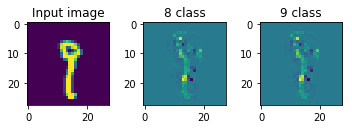

Label  2
Prediction 7


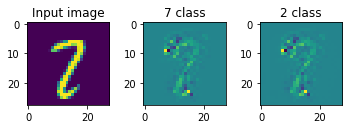

Label  6
Prediction 0


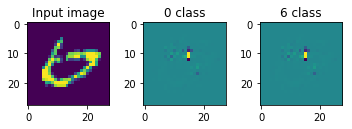

Label  6
Prediction 4


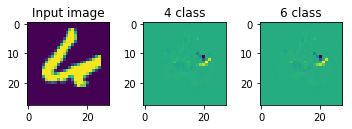

In [9]:
count = 0
for num, (image, label) in enumerate(test_loader):
    if count > 3:
        break
    output = lrp.forward(image)
    if output.argmax() != label:
        count += 1
        print('Label ', label.item())
        print('Prediction', output.argmax().item())
        _, ax = plt.subplots(1,3, figsize=(5,5))
        ax[0].imshow(image.squeeze())
        ax[0].title.set_text('Input image')
       
        R1 = torch.zeros_like(output)
        R1[0, output.argmax().item()] = 1
        
        relevance1 = lrp.relprop(R1*output)
        #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
        ax[1].imshow(norm_tensor(relevance1.squeeze()))
        ax[1].title.set_text('{} class'.format(output.argmax().item()))
        
        R2 = torch.zeros_like(output)
        R2[0, label.item()] = 1
        
        relevance2 = lrp.relprop(R2*output)
        #ax[2].imshow(cmap(norm_tensor(relevance2.squeeze())))
        ax[2].imshow(norm_tensor(relevance2.squeeze()))
        ax[2].title.set_text('{} class'.format(label.item()))
        plt.tight_layout()
        plt.show()

# Neuron selection. Iteration over outputs

In [ ]:
image, label = next(iter(test_loader))

output = lrp.forward(image)
for selected_neuron in range(10):
    _, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(image.squeeze())
    ax[0].title.set_text('Input image')

    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp(R1)
    #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
    ax[1].imshow(norm_tensor(relevance1.squeeze()))
    ax[1].title.set_text('Relevance of pixel \nto predition {} class'.format(selected_neuron))
    plt.show()
    print('Logit value {}'.format(output.squeeze().detach().numpy()[selected_neuron]))
    print('='*50)

# Uniform input. Interpretation of prediction

In [ ]:
image = torch.zeros((1, 1, 28, 28)) - 1e-6

output = lrp.forward(image)
for selected_neuron in range(10):
    _, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(image.squeeze())
    ax[0].title.set_text('Input image')

    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp(R1)
    #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
    ax[1].imshow(norm_tensor(relevance1.squeeze()))
    ax[1].title.set_text('Relevance of pixel \nto predition {} class'.format(selected_neuron))
    plt.show()
    print('Logit value {}'.format(output.squeeze().detach().numpy()[selected_neuron]))
    print('='*50)

## So if we include obtained relevance in input image, does it make it more class like for nn?

In [ ]:
image = torch.rand((1, 1, 28, 28))
initial_image = image
selected_neuron = 0 # choose number
out_log = []
for i in range(10): # tune iterations number
    output = lrp.forward(image)
#     _, ax = plt.subplots(1,2, figsize=(5,5))
#     ax[0].imshow(image.squeeze())
#     ax[0].title.set_text('Input image')
    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp(R1*output)
#     ax[1].imshow(norm_tensor(relevance1.squeeze()))
#     ax[1].title.set_text('Relevance image')
#     plt.show()

    image = image + image*relevance1*(relevance1>0).float() - image*relevance1*(relevance1<0).float() #*(torch.sign(output[:,selected_neuron].detach()))
    image = image - image.min()
    image = 2*image/image.max() - 1
    out_log.append(output.squeeze().detach().numpy())


for i in range(10):
    _ = plt.plot(np.array(out_log)[:, i], label=i, linewidth=6.0 if i==selected_neuron else 2.0)
plt.legend()
plt.show()
_, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(norm_tensor(initial_image.squeeze()))
ax[0].title.set_text('Initial image')
ax[1].imshow(norm_tensor(image.squeeze()))
ax[1].title.set_text('Relevanced image')
plt.show()

In [ ]:
(relevance1>0).shape

Obviouslly it's not so clear for convnet. Moreover why we subtrace relevance rather add?

# Occluded respectively to relevance

In [ ]:
image, label = next(iter(test_loader))
image_copy = copy.deepcopy(image)
image_copy_2 = copy.deepcopy(image)
selected_neuron = 7
number_of_corrupted_pixels = 50

fig, ax = plt.subplots(1,1, figsize=(5,5))
img = ax.imshow(image.squeeze())
ax.title.set_text('Input image')
fig.colorbar(img)
plt.show()


output = lrp.forward(image)
R1 = torch.zeros_like(output)
R1[0, selected_neuron] = 1
relevance = lrp(R1)

fig, ax = plt.subplots(1,1, figsize=(5,5))
img = ax.imshow(relevance.squeeze())
ax.title.set_text('Relevance')
fig.colorbar(img)
plt.show()

image_pixel_indx = torch.stack(torch.meshgrid([torch.range(0, x-1) for x in image.shape if x!=1]), 2).view(-1, 2).long()
flatten_image, sort_indx = torch.sort(relevance.abs().squeeze().flatten(), descending=True)
output_list = []
blank_image = torch.zeros((28,28))
for num, si in enumerate(sort_indx[:number_of_corrupted_pixels]):
#     if flatten_image[num] < 0:
#         print('Last positive relevance value was under nuver', num)
#         break
    image_copy[:,:,image_pixel_indx[si][0], image_pixel_indx[si][1]] = -1
    blank_image[image_pixel_indx[si][0], image_pixel_indx[si][1]] = 1
    output = lrp.forward(image_copy)
    output_list.append(output.squeeze().detach().numpy())

for i in range(10):
    _ = plt.plot(np.array(output_list)[:, i], label=i, linewidth=6.0 if i==selected_neuron else 2.0)
plt.legend()
plt.title('Degradation of logit over pixel flip respective to relevance')
plt.show()

flatten_random_image, sort_random_indx = torch.sort(torch.rand((28, 28)).flatten()*2-1, descending=True)
output_list_random = []
blank_image_random = torch.zeros((28,28))

for si in sort_random_indx[:number_of_corrupted_pixels]:
    image_copy_2[:,:,image_pixel_indx[si][0], image_pixel_indx[si][1]] = -1
    blank_image_random[image_pixel_indx[si][0], image_pixel_indx[si][1]] = 1
    output = lrp.forward(image_copy_2)
    output_list_random.append(output.squeeze().detach().numpy())
    
for i in range(10):
    _ = plt.plot(np.array(output_list_random)[:, i], label=i, linewidth=6.0 if i==selected_neuron else 2.0)
plt.legend()
plt.title('Degradation of logit over pixel flip randomly')
plt.show()

_ = plt.plot(np.array(output_list)[:, selected_neuron], label='relevance')
_ = plt.plot(np.array(output_list_random)[:, selected_neuron], label='random')
plt.legend()
plt.title('Comperison of degradetion')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(blank_image)
ax[0].title.set_text('relevance mask')
ax[1].imshow(blank_image_random)
ax[1].title.set_text('random mask')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(image_copy.squeeze())
ax[0].title.set_text('relevance corrupted image')
ax[1].imshow(image_copy_2.squeeze())
ax[1].title.set_text('random corrupted image')

# Overfit fully connected nn

In [ ]:
from train_mnist_model_overfit import Fcnn
model_over = Fcnn()
model_over.load_state_dict(torch.load('mnist_model_overfit_class5.ph'))
model_over = model_over.eval()
lrp_over = LRP(model_over, 'z_epsilon_rule')

In [ ]:
image = torch.ones_like(image) - 0.5
# image = next(iter(train_loader))[0]
output = lrp_over.forward(image)

for selected_neuron in range(10):
    fig, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(image.squeeze())
    ax[0].title.set_text('Input image')

    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp_over(R1*output)
    relevance1 = relevance1.view(28,28)
    #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
    img = ax[1].imshow(norm_tensor(relevance1.squeeze()))
    ax[1].title.set_text('Relevance of pixel \nto predition {} class'.format(selected_neuron))
    fig.colorbar(img)
    plt.show()
    print('Logit value {}'.format(output.squeeze().detach().numpy()[selected_neuron]))
    print('='*50)